In [1]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [29]:
#Risky Asset
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
#Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:] = .03 / 12

start = 1000
floor = .8

1. Cushion - (Asset Value - Floor Value)
2. Compute Allocation to safe and risky assets --> m*risk budget
3. Recompute the Asset Value based on returns

In [36]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = floor * start
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    risky_w = m*cushion
    risky_w = np.minimum(1, risky_w)
    risky_w = np.maximum(0, risky_w)
    safe_w = 1 - risky_w
    
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    
    account_value = (risky_alloc * (1 + risky_r.iloc[step])) + (safe_alloc * (1+safe_r.iloc[step]))
    
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

<AxesSubplot:>

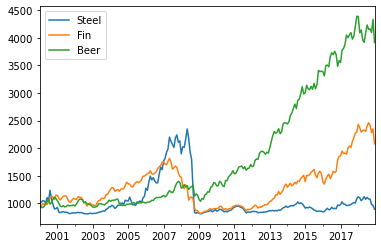

In [37]:
account_history.plot()

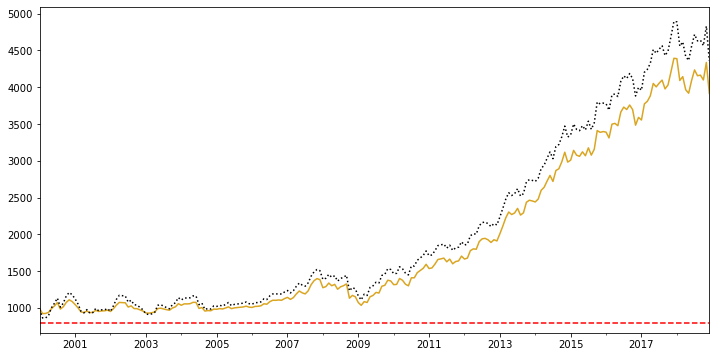

In [38]:
risky_wealth = start * (1+risky_r).cumprod()

ax = account_history['Beer'].plot(figsize = (12,6), color = 'goldenrod')
risky_wealth['Beer'].plot(ax=ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')


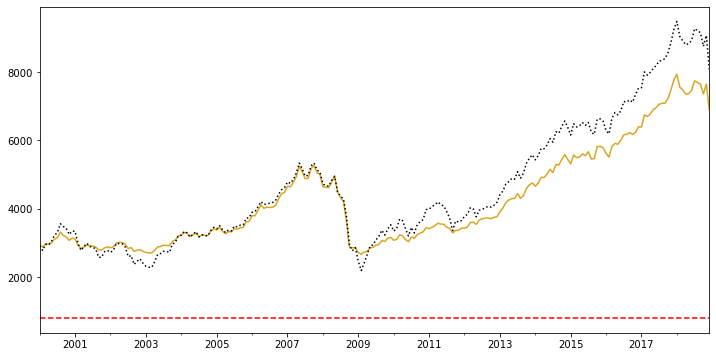

In [43]:
ax = account_history.sum(axis = 'columns').plot(figsize = (12,6), color = 'goldenrod')
risky_wealth.sum(axis = 'columns').plot(ax=ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

<AxesSubplot:>

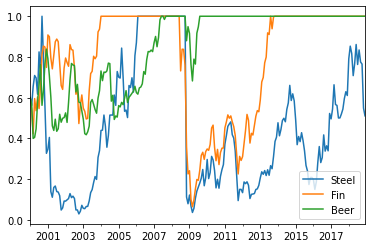

In [45]:
risky_w_history.plot()
#If you keep a fixed floor, then pretty soon it becomes irrelevant, because if floor is 1k and your account reaches 10k, the odds of you hitting 1k are nearly 0
#so you end up simply going 100% into risky assets anyways (as we see here in beer and finance)

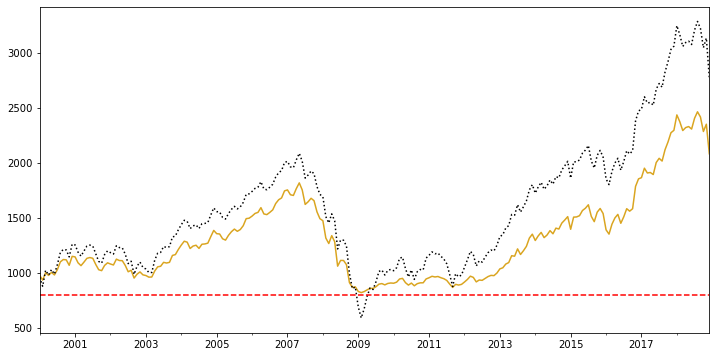

In [46]:
ind = 'Fin'
ax = account_history[ind].plot(figsize = (12,6), color = 'goldenrod')
risky_wealth[ind].plot(ax=ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

###CPI has more of an effect here, if you weren't using CCPI you would have crashed through the floor
### but in our case we nicely bounce off (but then miss out on upside)


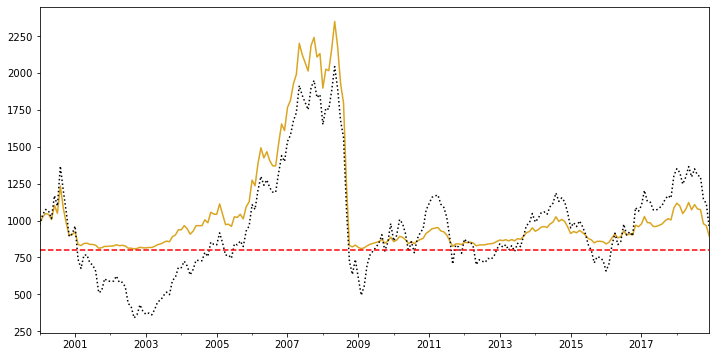

In [47]:
ind = 'Steel'
ax = account_history[ind].plot(figsize = (12,6), color = 'goldenrod')
risky_wealth[ind].plot(ax=ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

###CPI has more of an effect here, if you weren't using CCPI you would have crashed through the floor
### but in our case we nicely bounce off (but then miss out on upside)


In [49]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [51]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot:>

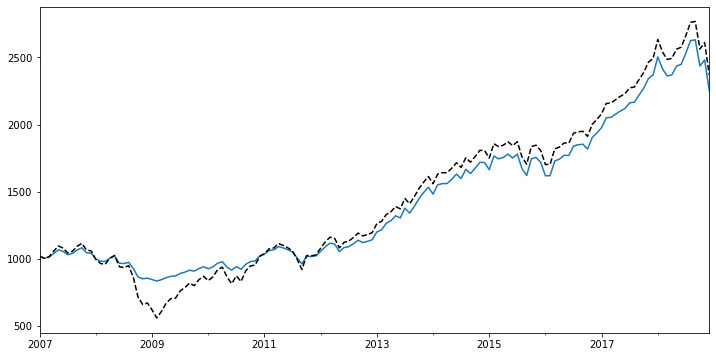

In [52]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12,6), legend = False)
btr['Risky Wealth'].plot(ax=ax, style = 'k--', legend = False)

In [54]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [57]:
erk.summary_stats(btr['Wealth'].pct_change().dropna()) #look how much better the max drawdown is, and the VAR

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


# Drawdown Constraint

<AxesSubplot:>

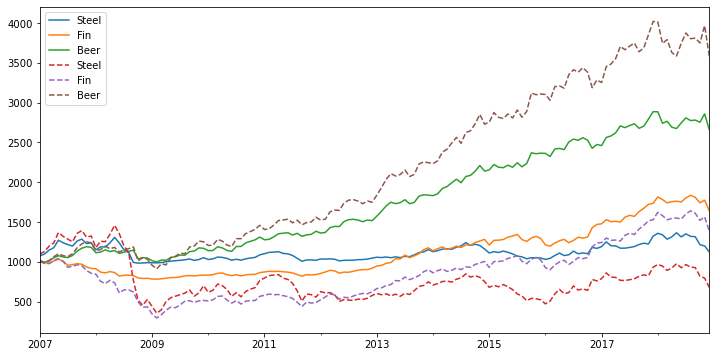

In [61]:
# now we add a drawdown consraint to PPI by making floor into a changing value
btr = erk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown = .25)
ax = btr['Wealth'].plot(figsize=(12,6))
btr['Risky Wealth'].plot(ax=ax, style = '--')

In [62]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [63]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
